
... ***CURRENTLY UNDER DEVELOPMENT*** ...


### TODO


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from datetime import datetime


# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.rbf import RBF_Interpolation
from teslakit.mda import Normalize

from teslakit.plotting.extremes import Plot_ReturnPeriodValidation
from teslakit.plotting.estela import Plot_DWTs_Probs
from teslakit.plotting.wts import Plot_Probs_WT_WT


In [2]:
#-----------------
# ACLARACIONES!!!!
#-----------------

# La validación de los datos de periodo de retorno de máximos anuales de volumen de inundación no quedan bien
# (diferencias de un orden de magnitud). 

# Aunque supongo que saldrá bien, la validación de las olas nearshore en los 3 puntos donde se guardan los 
# resultados de swan (y antes de hacer snell) no se ha hecho, pero la validación de las olas de emulador offshore
# sí era aceptable así que...

# Un punto débil puede estar en que los casos simulados con swash no cubren bien todos los datos del emulador (esto creo
# que era sobre todo para los perfiles del sector N)

# También puede estar afectando los NaNs en los datos de caudal (lo que decía AlbaR de los datos de viento con direcciones
# en contra del perfil....)

# También que los caudales que salen aquí en Kwajalein son muy pequeños (aunque nunca 0, siempre hay algo de rebase??)
# He considerado que en cada perfil, no había rebase (caudal=0) si el caudal era inferior a 0.001 l/s/m.

# En las simulaciones de SLR, para separar los eventos de inundación he añadido un umbral de 0.01 l/s/m en la suma 
# de todos los perfiles, si no quedaban eventos de muchisima duración

# No he multiplicado los caudales por la distancia entre perfiles porque la separación entre perfiles es constante 
# (creo que 300m), así que las unidades son por metro lineal




## Database and Site parameters

In [3]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
site = 'KWAJALEIN_emulator'
db.SetSite(site)


# Simulation to plot DWTs and AT
nsim=1


## Load Hyswash simulations

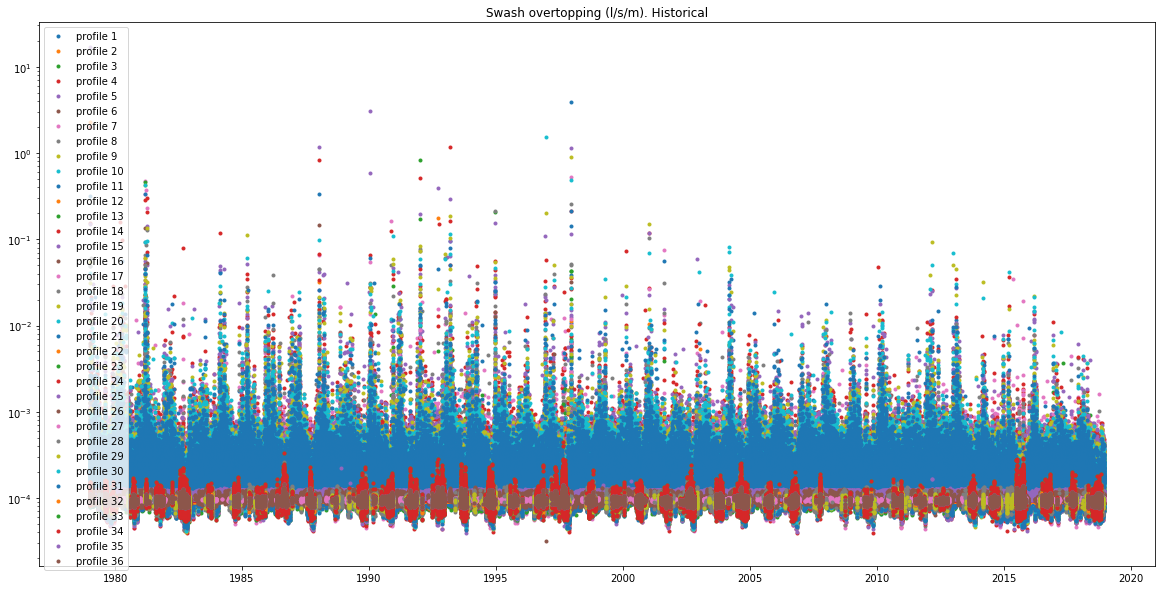

In [4]:
#-------------------------------
# Load historical data

hist_swells = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/HySwash_outputs/Historical_swells_tcs/swells_HySwash.nc')
hist_TCs = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/HySwash_outputs/Historical_swells_tcs/tcs_HySwash.nc')


plt.figure(figsize=(20,10))
for p in hist_swells.profile.values:
    plt.plot(hist_swells.time, hist_swells.Qinv.sel(profile=p), '.' ,label=('profile ' + str(p)))
plt.legend()
plt.title('Swash overtopping (l/s/m). Historical')
plt.yscale('log')


# TODO: incluir TCs (las olas de TCs son casi siempre menores...así que no creo que vaya a cambiar gran cosa)
qru_hist = hist_swells.copy(deep=True)


# Compara olas de clima regular y TCs en cada perfil
#for p in hist_swells.profile:
#    plt.figure(figsize=(20,5))
#    plt.plot(hist_swells.time, hist_swells.Qinv.sel(profile=p), '.' ,label='swell')
#    plt.plot(hist_TCs.time, hist_TCs.Qinv.sel(profile=p), '.', label='TCs')
#    plt.legend()
#    plt.title('profile ' + str(p))


In [5]:
#-------------------------------
# Load simulation data

# Load overtopping & runup q(l/s/m). ru2(m)

p_base = '/Users/albacid/Projects/SERDP/inputs_Kwajalein/HySwash_outputs/Sims'

sim_ini=0
sim_end=9

qru = xr.concat(
    [xr.open_dataset(op.join(p_base, 'Sim_{0}.nc'.format(i))).drop({'ru2'}).assign_coords(n_sim=i).expand_dims('n_sim') for i in range(sim_ini,sim_end+1)], 
    dim='n_sim'
)

print(qru)


<xarray.Dataset>
Dimensions:  (n_sim: 10, profile: 36, time: 8765832)
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2999-12-31 23:00:00.13
  * profile  (profile) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0 36.0
  * n_sim    (n_sim) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    q        (n_sim, profile, time) float64 nan nan nan nan ... nan nan nan nan


In [6]:
# Hay nans en los datos simulados:

#for p in qru_2.profile.values:
#    print('profile ' + str(p))
#    
#    kk = qru_2.q.sel(profile=p)
#    print(len(kk.values))
#
#    kk = kk.where(~np.isnan(kk), drop=True)
#    print(len(kk.values))
#    print()
     
    
# sustituir NaNs por 0
qru = qru.where(~np.isnan(qru.q), 0)
print(qru)

qru_hist = qru_hist.where(~np.isnan(qru_hist.Qinv), 0)
print(qru_hist)


<xarray.Dataset>
Dimensions:  (n_sim: 10, profile: 36, time: 8765832)
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2999-12-31 23:00:00.13
  * profile  (profile) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0 36.0
  * n_sim    (n_sim) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    q        (n_sim, profile, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
<xarray.Dataset>
Dimensions:  (profile: 36, time: 340362)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-16T10:00:00
  * profile  (profile) int64 1 2 3 4 5 6 7 8 9 10 ... 28 29 30 31 32 33 34 35 36
Data variables:
    ru2      (profile, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Qinv     (profile, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0


In [7]:
# Load DWTs & AT. Only for plotting comparison

#--------------
# Historical
HIST_C_h = db.Load_HIST_OFFSHORE(vns=['DWT', 'AWT', 'AT'],decode_times=True)

# remove NaNs
HIST_C_h = HIST_C_h.where(~np.isnan(HIST_C_h.DWT), drop=True)
HIST_C_h = HIST_C_h.where(~np.isnan(HIST_C_h.AWT), drop=True)
HIST_C_h = HIST_C_h.where(~np.isnan(HIST_C_h.AT), drop=True)
print(HIST_C_h)
print()


#--------------
# Simulations. Load one simulation
offshore_vars = db.Load_SIM_OFFSHORE(n_sim=nsim, vns=['DWT', 'AWT', 'AT'], decode_times=True, use_cftime=True)
print(offshore_vars)


<xarray.Dataset>
Dimensions:  (time: 349608)
Coordinates:
  * time     (time) datetime64[ns] 1979-02-13 ... 2018-12-31T23:00:00
Data variables:
    DWT      (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 33.0 33.0 33.0 33.0 33.0
    AWT      (time) float64 4.0 4.0 4.0 4.0 4.0 4.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
    AT       (time) float64 -0.6199 -0.359 0.001621 ... -0.2365 -0.05054 0.143

<xarray.Dataset>
Dimensions:  (time: 8765832)
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2999-12-31 23:00:00.13
Data variables:
    DWT      (time) float32 ...
    AWT      (time) float32 ...
    AT       (time) float32 ...


In [8]:
# Seleccion de los 100 primeros años (quitar??)

qru = qru.isel(time=slice(0, 876583))
offshore_vars = offshore_vars.isel(time=slice(0, 876583))

print(qru)
print()
print(offshore_vars)

<xarray.Dataset>
Dimensions:  (n_sim: 10, profile: 36, time: 876583)
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2099-12-31 06:00:00
  * profile  (profile) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0 36.0
  * n_sim    (n_sim) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    q        (n_sim, profile, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

<xarray.Dataset>
Dimensions:  (time: 876583)
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2099-12-31 06:00:00
Data variables:
    DWT      (time) float32 ...
    AWT      (time) float32 ...
    AT       (time) float32 ...


In [9]:
# DatetimeGregorian to datetime
time = [x.timetuple() for x in qru.time.values];
time = [datetime(*x[:6]) for x in time];

qru['time'] = time
offshore_vars['time'] = time


# round times to hour
qru['time'] = qru['time'].dt.round('H')
offshore_vars['time'] = offshore_vars['time'].dt.round('H')


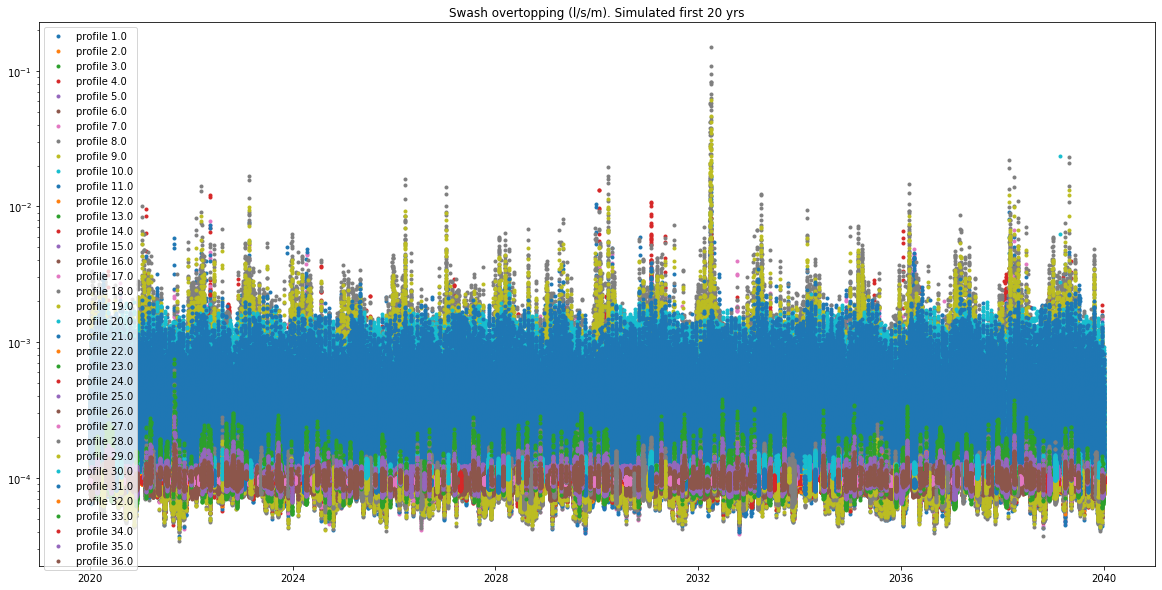

In [10]:
# Plot 20 years of simulated data for one simulation

qru_plot = qru.sel(time=slice(datetime(2020,1,1), datetime(2040,1,1))).copy(deep=True)

plt.figure(figsize=(20,10))
for p in qru_plot.profile.values:
    plt.plot(qru_plot.time, qru_plot.q.sel(n_sim=nsim, profile=p), '.' ,label=('profile ' + str(p)))
plt.legend()
plt.title('Swash overtopping (l/s/m). Simulated first 20 yrs')
plt.yscale('log')


## Extreme events: Annual Maxima inundation volumes

<xarray.Dataset>
Dimensions:  (profile: 36, time: 340362)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-16T10:00:00
  * profile  (profile) int64 1 2 3 4 5 6 7 8 9 10 ... 28 29 30 31 32 33 34 35 36
Data variables:
    ru2      (profile, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Qinv     (profile, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

<xarray.Dataset>
Dimensions:  (time: 340362)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-16T10:00:00
Data variables:
    ru2      (time) float64 -1.296 -0.9848 -0.6548 3.868 ... 0.1186 12.79 0.9057
    Qinv     (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0


<xarray.Dataset>
Dimensions:  (n_sim: 10, profile: 36, time: 876583)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2099-12-31T06:00:00
  * profile  (profile) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0 36.0
  * n_sim    (n_sim) int64 0 1 2 3 4 5 6 7 8 9
Data variable

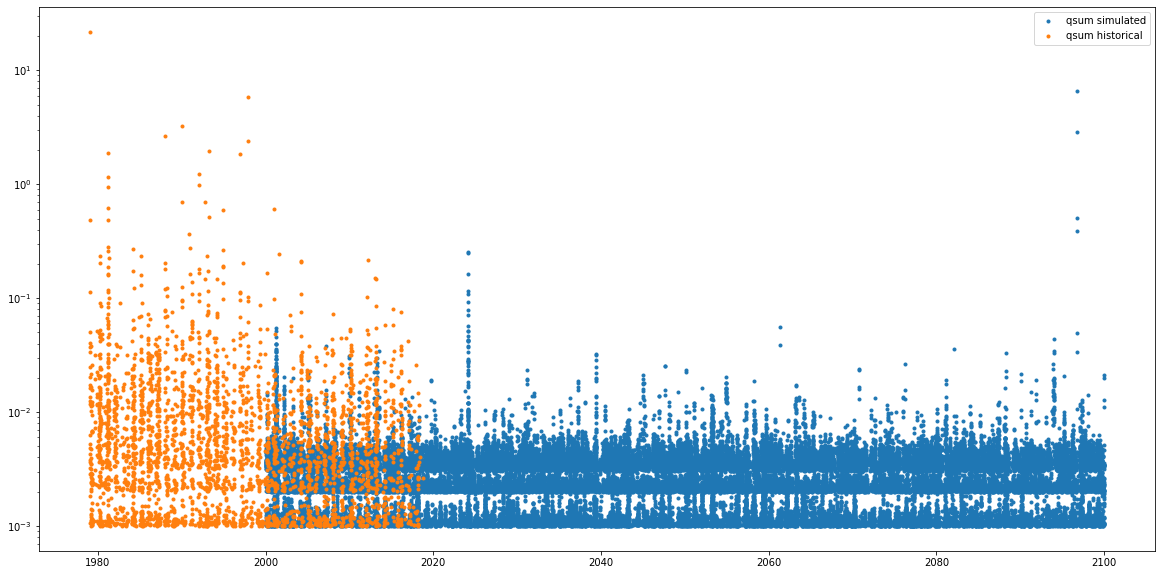

In [37]:
#--------------------------
# Historical data

# Neglect values in each profile where Q<0.001 l/s/m (neglegible)
qru_hist['Qinv'] = qru_hist.Qinv.where(qru_hist.Qinv.values>=0.001, 0)

# Sum all profiles. threshold 0.01
qru_hist_all = qru_hist.sum(dim='profile')

print(qru_hist)
print()
print(qru_hist_all)
print()
print()


#--------------------------
# Simulations

# Neglect values in each profile where Q<0.001 l/s/m (neglegible)
qru['q'] = qru.q.where(qru.q.values>=0.001, 0)

# Sum all profiles. threshold 0.01
qru_all = qru.sum(dim='profile')

print(qru)
print()
print(qru_all)


# plot Q sum for historical and one simulation of simulated data 
plt.figure(figsize=(20,10))
plt.plot(qru_all.time, qru_all.q.sel(n_sim=kk), '.' ,label='qsum simulated')
plt.plot(qru_hist_all.time, qru_hist_all.Qinv, '.' ,label='qsum historical')
plt.legend()
plt.yscale('log')

#### Overtopping to inundation volumes: Historical

In [19]:
# Create new variable
qru_hist_all['inundation_vol'] = qru_hist_all.Qinv*np.nan


# identify peaks
ind = np.where(qru_hist_all.Qinv!=0)[0]

ind2 = np.where(np.diff(ind)!=1)[0]
ind2 = np.concatenate(([-1],ind2)) # fix last event?

# new var for qru_hist_all
ed_vol = np.zeros(len(qru_hist_all.time))*np.nan

for ix in range(len(ind2)-1):      
    ix1 = ind2[ix]+1
    ix2 = ind2[ix+1]+1

    ind_t = ind[ix1:ix2]
    q_peak = qru_hist_all.Qinv[ind_t] # l/s/m
    
    # overtopping to inundation volume
    vol = np.sum(q_peak.values)*3600 # l/m. los datos son horarios, cada valor de caudal se multiplica por la duracion.

    ind_max = np.argmax(q_peak.values)
    ind_max = ind_t[ind_max]

    ed_vol[ind_max] = vol

    
qru_hist_all['inundation_vol'] = (('time'), ed_vol) # inundation volume of each event (l/m)
    
qru_hist_all['inundation_vol'] = qru_hist_all['inundation_vol'].where(~np.isnan(qru_hist_all['inundation_vol']), 0)
print(qru_hist_all)


<xarray.Dataset>
Dimensions:         (time: 340362)
Coordinates:
  * time            (time) datetime64[ns] 1979-01-01 ... 2018-12-16T10:00:00
Data variables:
    ru2             (time) float64 -1.296 -0.9848 -0.6548 ... 12.79 0.9057
    Qinv            (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    inundation_vol  (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0


#### Overtopping to inundation volumes: Simulations

In [20]:
# Create new variable
qru_all['inundation_vol'] = qru_all.q*np.nan

for n in qru_all.n_sim:
    
    qru_all_nsim = qru_all.q.sel(n_sim=n)
    
    # identify peaks
    ind = np.where(qru_all_nsim!=0)[0]

    ind2 = np.where(np.diff(ind)!=1)[0]
    ind2 = np.concatenate(([-1],ind2)) # fix last event?

    # new var for qru_all
    ed_vol = np.zeros(len(qru_all.time))*np.nan

    for ix in range(len(ind2)-1):      
        ix1 = ind2[ix]+1
        ix2 = ind2[ix+1]+1

        ind_t = ind[ix1:ix2]
        q_peak = qru_all_nsim[ind_t] # l/s/m
        vol = np.sum(q_peak.values)*3600 # l/m. los datos son horarios, cada valor de caudal se multiplica por la duracion.
        
        ind_max = np.argmax(q_peak.values)
        ind_max = ind_t[ind_max]
        
        ed_vol[ind_max] = vol

    qru_all['inundation_vol'][n,:] = ed_vol # inundation volume of each event (l/m)
    
    
qru_all['inundation_vol'] = qru_all['inundation_vol'].where(~np.isnan(qru_all['inundation_vol']), 0)
print(qru_all)


<xarray.Dataset>
Dimensions:         (n_sim: 10, time: 876583)
Coordinates:
  * time            (time) datetime64[ns] 2000-01-01 ... 2099-12-31T06:00:00
  * n_sim           (n_sim) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    q               (n_sim, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    inundation_vol  (n_sim, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0


#### Annual maxima of inundation volumes

In [21]:
# def. some auxiliar function to select all dataset variables at vn max by groups

def grouped_max(ds, vn=None, dim=None):
    return ds.isel(**{dim: ds[vn].argmax(dim)})


In [22]:
# -------------------------------------------------------------------------
# Obtain instant of annual maxima overtopping from the sum of all profiles

# Historical
vol_hist_all_AMax = qru_hist_all.groupby('time.year').apply(grouped_max, vn='inundation_vol', dim='time')
print(vol_hist_all_AMax)
print()

# Simulation
vol_all_AMax = qru_all.groupby('time.year').apply(grouped_max, vn='inundation_vol', dim='time')
print(vol_all_AMax)
print()



# Hay años donde el máximo vol de inundación es 0??:
print('----------')
print(len(vol_hist_all_AMax.year.where(vol_hist_all_AMax.inundation_vol!=0,drop=True)))

for n in vol_all_AMax.n_sim.values:
    print(len(vol_all_AMax.year.where(vol_all_AMax.inundation_vol.isel(n_sim=n)!=0,drop=True)))


<xarray.Dataset>
Dimensions:         (year: 40)
Coordinates:
    time            (year) datetime64[ns] 1979-01-03T09:00:00 ... 2018-02-14T03:00:00
  * year            (year) int64 1979 1980 1981 1982 ... 2015 2016 2017 2018
Data variables:
    ru2             (year) float64 22.94 27.47 24.88 15.4 ... 19.92 26.78 20.19
    Qinv            (year) float64 21.71 0.2363 1.885 ... 0.02605 0.01464
    inundation_vol  (year) float64 7.817e+04 850.7 6.787e+03 ... 93.77 52.72

<xarray.Dataset>
Dimensions:         (n_sim: 10, year: 100)
Coordinates:
  * n_sim           (n_sim) int64 0 1 2 3 4 5 6 7 8 9
    time            (year, n_sim) datetime64[ns] 2000-03-18T04:00:00 ... 2099-12-14T06:00:00
  * year            (year) int64 2000 2001 2002 2003 ... 2096 2097 2098 2099
Data variables:
    q               (year, n_sim) float64 0.04382 0.05169 ... 0.05163 0.02105
    inundation_vol  (year, n_sim) float64 561.1 544.0 308.2 ... 678.1 267.4

----------
40
100
100
100
100
100
100
100
100
100
100


### Save annual maxima events at each profile for LisFlood


In [23]:
# Obtain annual maxima events

def peaks_cleaner(xmax, xda):
    '''
    Locates annual maxima and attached variable peak, cleans everything else
    
    xda - input data array
    '''
    
    # initialize output (clean data array)
    xda_clean = xda.copy(deep=True)
    xda_clean.values[:] = np.nan
    
    # find all ZERO values (peaks must start and end at val=0)
    ix_zs = np.where(xda.values[:] == 0)[0]
    
    # clean data year by year
    for t_peak in xmax.time.values[:]:
        
        # find peak max index, locate this index "zero indexes" left and right neighbours
        ix_p = np.where(t_peak == xda.time)[0]
        
        ix_z0 = ix_zs[np.where(ix_zs<ix_p)[0][-1]] +1 # first zero to the left
        ix_z1 = ix_zs[np.where(ix_zs>ix_p)[0][0]]  # first zero to the right
        
        # fill clean output with main peak values
        xda_clean.values[ix_z0:ix_z1] = xda.values[ix_z0:ix_z1]
    
    return xda_clean

In [24]:
# Select events at each profile for each n_sim

qru_out = qru.copy(deep=True)

for n in qru_all.n_sim.values:

    time_AMax_nsim = vol_all_AMax.time.sel(n_sim=n)  
    qru_all_nsim = qru_all.sel(n_sim=n)  
                
    qru_all_nsim_Amax = peaks_cleaner(time_AMax_nsim, qru_all_nsim.q)
   
    # keep these peaks for each profile
    for p in qru.profile.values:

        temp = qru.q.sel(n_sim=n, profile=p)
        temp = temp.where(~np.isnan(qru_all_nsim_Amax.values), np.nan)
        
        qru_out.q[int(n),int(p-1),:] = temp  

        

# SAVE to_netcdf
qru_out.to_netcdf('/Users/albacid/Projects/TeslaKit_projects/sites/' + site + '/q_profiles_Amax.nc')


(748802.0, 748805.0)

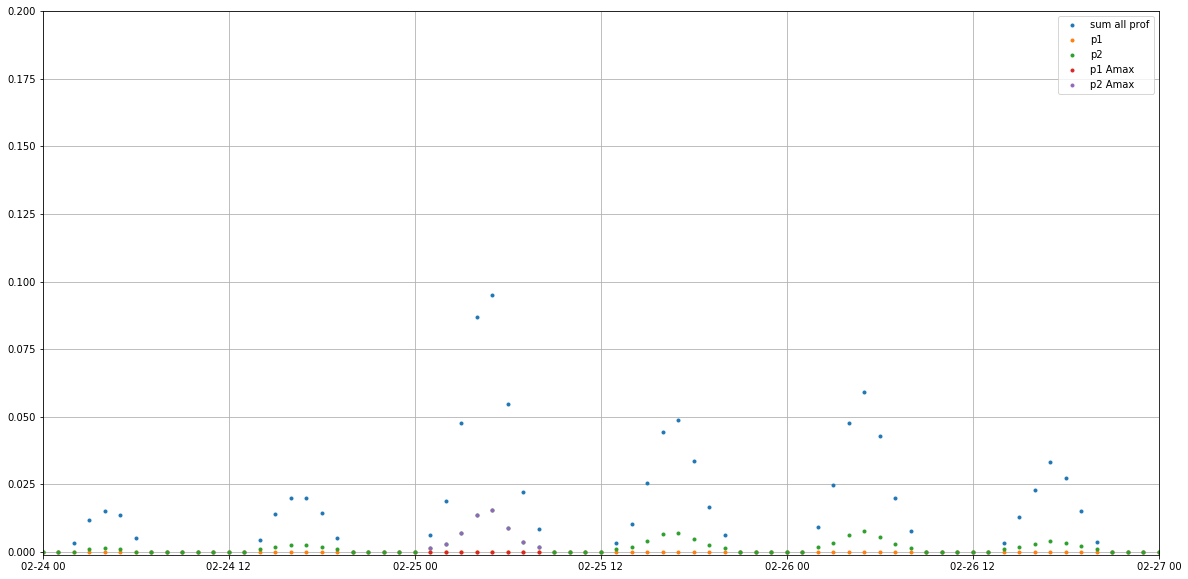

In [25]:
# Plot 

n=1
p1=3
p2=15

#print(vol_all_AMax.time.sel(n_sim=n))

plt.figure(figsize=(20,10))
plt.plot(qru_all.time, qru_all.q.sel(n_sim=n), '.', label='sum all prof')
plt.plot(qru.time, qru.q.sel(n_sim=n, profile=p1), '.', label='p1')
plt.plot(qru.time, qru.q.sel(n_sim=n, profile=p2), '.', label='p2')

plt.plot(qru_out.time, qru_out.q.sel(n_sim=n, profile=p1), '.', label='p1 Amax')
plt.plot(qru_out.time, qru_out.q.sel(n_sim=n, profile=p2), '.', label='p2 Amax')

plt.legend()
plt.grid()
plt.ylim(-0.001,.2)
plt.xlim(datetime(2051,2,24), datetime(2051,2,27))
#plt.xlim(datetime(2071,2,14), datetime(2071,2,16))

#print(qru_all.q.sel(n_sim=n, time=slice(datetime(2071,2,14), datetime(2071,2,16))))
#print(qru_out.q.sel(n_sim=n,  profile=p1, time=slice(datetime(2071,2,14), datetime(2071,2,16))))
#print(qru_out.q.sel(n_sim=n,  profile=p2, time=slice(datetime(2071,2,14), datetime(2071,2,16))))

#print(qru_all.q.sel(n_sim=n, time=datetime(2071,2,15,3)))


## Return periods from Annual Maxima inundation volumes

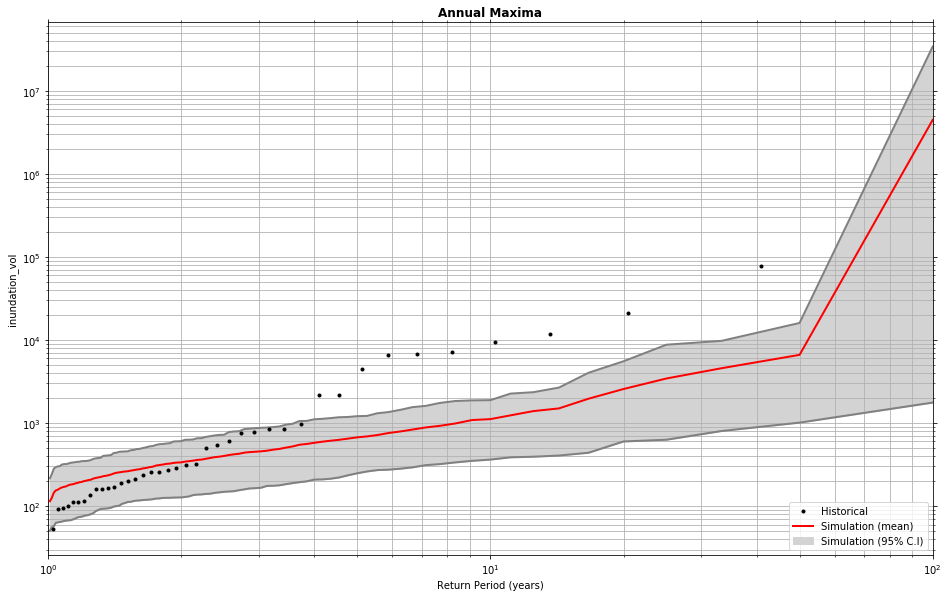

In [27]:
fig = Plot_ReturnPeriodValidation(vol_hist_all_AMax['inundation_vol'], vol_all_AMax['inundation_vol'].transpose(), show=False);
plt.gca().set_yscale('log')


### Save return periods of annual maxima events at each profile for LisFlood 


In [28]:
# TODO: revisar esta función

#--------------------------
# Obtain Return periods:

# aux func for calculating rp time
def t_rp(time_y):
    ny = len(time_y)
    return np.array([1/(1-(n/(ny+1))) for n in np.arange(1,ny+1)])
    
    
# RP calculation, var sorting simulation
t_s = t_rp(vol_all_AMax.year.values[:-1])  # remove last year*
t_s = np.concatenate(([1],t_s))


# create dataset with sorted inundation volumes
xds = xr.Dataset({'vol_sorted': (('return_period','n_sim'), np.zeros(np.shape(vol_all_AMax['inundation_vol']))*np.nan)},
    coords = {'return_period': t_s})

for n in vol_all_AMax.n_sim.values:
    xds['vol_sorted'][:,n] = np.sort(vol_all_AMax['inundation_vol'].sel(n_sim=n).values[:])  

    
# Add associated return period to each year    
sims_rp = np.zeros((len(vol_all_AMax.time), len(vol_all_AMax.n_sim))) * np.nan

# solve each simulation
for n in vol_all_AMax.n_sim:
    
    # get annual maxima
    amax = vol_all_AMax.sel(n_sim=n)['inundation_vol']
    
    # solve each year
    for cy, y in enumerate(amax.year):
        
        # get return period for this year
        ay = amax.sel(year=y).values
        ix = np.where(xds['vol_sorted'].sel(n_sim=n).values[:]==ay)[0][0]
        ay_rp = xds['return_period'].values[ix]
        
        # store data
        sims_rp[cy, n] = ay_rp

# add return periods to dataset
vol_all_AMax['return_period'] = (('year','n_sim'), sims_rp)

print(vol_all_AMax)

    
        

<xarray.Dataset>
Dimensions:         (n_sim: 10, year: 100)
Coordinates:
  * n_sim           (n_sim) int64 0 1 2 3 4 5 6 7 8 9
    time            (year, n_sim) datetime64[ns] 2000-03-18T04:00:00 ... 2099-12-14T06:00:00
  * year            (year) int64 2000 2001 2002 2003 ... 2096 2097 2098 2099
Data variables:
    q               (year, n_sim) float64 0.04382 0.05169 ... 0.05163 0.02105
    inundation_vol  (year, n_sim) float64 561.1 544.0 308.2 ... 678.1 267.4
    return_period   (year, n_sim) float64 1.887 2.703 1.818 ... 1.299 2.222 6.25


In [29]:
# Select events at each profile for each n_sim for selected return periods (RP)

qru_out = qru.copy(deep=True)

for RP in [1,2,4,5,10,20,50,100]:
    for n in qru_all.n_sim.values:

        vol_all_AMax_nsim = vol_all_AMax.sel(n_sim=n).copy(deep=True)
        vol_all_AMax_nsim['return_period'] = (('year'),np.round(vol_all_AMax_nsim.return_period.values,2))
        
        time_AMax_nsim = vol_all_AMax_nsim.time.where(vol_all_AMax_nsim.return_period==RP, drop=True)
        qru_all_nsim = qru_all.sel(n_sim=n)  

        qru_all_nsim_Amax = peaks_cleaner(time_AMax_nsim, qru_all_nsim.q)
    
        # keep these peaks for each profile
        for p in qru.profile.values:

            temp = qru.q.sel(n_sim=n, profile=p)
            temp = temp.where(~np.isnan(qru_all_nsim_Amax.values), np.nan)

            qru_out.q[int(n),int(p-1),:] = temp  


    # SAVE to_netcdf
    qru_out.to_netcdf('/Users/albacid/Projects/TeslaKit_projects/sites/' + site + '/q_profiles_RP_' + str(RP) + 'yr.nc')

## DWT and AT associated to Annual maxima events

In [30]:
# ------------------
# Simulation

offshore_vars['AT_category'] = offshore_vars.AT*np.nan


# Tide values <= 0 assign to cat 1
ind = np.where(offshore_vars.AT <=0)[0]
offshore_vars['AT_category'][ind] = 1


# Tide values >0 assign to cat 2-6
AT_positive = offshore_vars.AT.where(offshore_vars.AT>0, drop=True)
AT_perc = np.percentile(AT_positive.values, [50, 75, 95, 99, 100])

# cat 1
ind = np.where((offshore_vars.AT > 0) & (offshore_vars.AT <= AT_perc[0]))[0]
offshore_vars['AT_category'][ind] = 2

# cat 2
ind = np.where((offshore_vars.AT > AT_perc[0]) & (offshore_vars.AT <= AT_perc[1]))[0]
offshore_vars['AT_category'][ind] = 3

# cat 3
ind = np.where((offshore_vars.AT > AT_perc[1]) & (offshore_vars.AT <= AT_perc[2]))[0]
offshore_vars['AT_category'][ind] = 4

# cat 4
ind = np.where((offshore_vars.AT > AT_perc[2]) & (offshore_vars.AT <= AT_perc[3]))[0]
offshore_vars['AT_category'][ind] = 5

# cat 5
ind = np.where((offshore_vars.AT > AT_perc[3]) & (offshore_vars.AT <= AT_perc[4]))[0]
offshore_vars['AT_category'][ind] = 6


print('AT cat 1:', '<0')
print('AT cat 2:', 0, '-', round(AT_perc[0],4))
print('AT cat 3:', round(AT_perc[0],4), '-',  round(AT_perc[1],4))
print('AT cat 4:', round(AT_perc[1],4), '-',  round(AT_perc[2],4))
print('AT cat 5:', round(AT_perc[2],4), '-',  round(AT_perc[3],4))
print('AT cat 6:', round(AT_perc[3],4), '-',  round(AT_perc[4],4))
print()
print(offshore_vars)


AT cat 1: <0
AT cat 2: 0 - 0.3039
AT cat 3: 0.3039 - 0.4972
AT cat 4: 0.4972 - 0.77
AT cat 5: 0.77 - 0.9031
AT cat 6: 0.9031 - 1.068

<xarray.Dataset>
Dimensions:      (time: 876583)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-01 ... 2099-12-31T06:00:00
Data variables:
    DWT          (time) float32 ...
    AWT          (time) float32 ...
    AT           (time) float32 ...
    AT_category  (time) float32 2.0 2.0 2.0 2.0 2.0 1.0 ... 1.0 1.0 2.0 3.0 4.0


In [31]:
# ------------------
# Historical

HIST_C_h['AT_category'] = HIST_C_h.AT*np.nan


# Tide values <= 0 assign to cat 1
ind = np.where(HIST_C_h.AT <=0)[0]
HIST_C_h['AT_category'][ind] = 1


# Tide values >0 assign to cat 2-6

# cat 1
ind = np.where((HIST_C_h.AT > 0) & (HIST_C_h.AT <= AT_perc[0]))[0]
HIST_C_h['AT_category'][ind] = 2

# cat 2
ind = np.where((HIST_C_h.AT > AT_perc[0]) & (HIST_C_h.AT <= AT_perc[1]))[0]
HIST_C_h['AT_category'][ind] = 3

# cat 3
ind = np.where((HIST_C_h.AT > AT_perc[1]) & (HIST_C_h.AT <= AT_perc[2]))[0]
HIST_C_h['AT_category'][ind] = 4

# cat 4
ind = np.where((HIST_C_h.AT > AT_perc[2]) & (HIST_C_h.AT <= AT_perc[3]))[0]
HIST_C_h['AT_category'][ind] = 5

# cat 5
ind = np.where((HIST_C_h.AT > AT_perc[3]) & (HIST_C_h.AT <= AT_perc[4]))[0]
HIST_C_h['AT_category'][ind] = 6


print(HIST_C_h)


<xarray.Dataset>
Dimensions:      (time: 349608)
Coordinates:
  * time         (time) datetime64[ns] 1979-02-13 ... 2018-12-31T23:00:00
Data variables:
    DWT          (time) float64 1.0 1.0 1.0 1.0 1.0 ... 33.0 33.0 33.0 33.0 33.0
    AWT          (time) float64 4.0 4.0 4.0 4.0 4.0 4.0 ... 2.0 2.0 2.0 2.0 2.0
    AT           (time) float64 -0.6199 -0.359 0.001621 ... -0.05054 0.143
    AT_category  (time) float64 1.0 1.0 2.0 3.0 4.0 5.0 ... 1.0 1.0 1.0 1.0 2.0


In [32]:
# -------------------------------------------------------------------------
# Select variables at annual maxima. Choose one simulation

HIST_C_h_Amax = HIST_C_h.sel(time=vol_hist_all_AMax.time[1:]) # HIST_C_h empieza en Feb 1979, no hay enero, que es donde sucede el primer máximo


# Delete values where annual max vol is 0
vol_all_AMax_nsim = vol_all_AMax.sel(n_sim=nsim)
vol_all_AMax_nsim = vol_all_AMax_nsim.where(vol_all_AMax_nsim.return_period!=0, drop=True)

offshore_vars_AMax = offshore_vars.sel(time=vol_all_AMax_nsim.time)

print(HIST_C_h_Amax)
print(offshore_vars_AMax)
print()


u, indices = np.unique(HIST_C_h_Amax.AT_category, return_counts=True)

print(u)
print(indices)
print()

u, indices = np.unique(offshore_vars_AMax.AT_category, return_counts=True)
print(u)
print(indices)


<xarray.Dataset>
Dimensions:      (year: 39)
Coordinates:
    time         (year) datetime64[ns] 1980-04-16T18:00:00 ... 2018-02-14T03:00:00
  * year         (year) int64 1980 1981 1982 1983 1984 ... 2015 2016 2017 2018
Data variables:
    DWT          (year) float64 1.0 40.0 21.0 9.0 1.0 ... 20.0 32.0 7.0 1.0 32.0
    AWT          (year) float64 2.0 5.0 1.0 5.0 5.0 6.0 ... 4.0 2.0 1.0 3.0 3.0
    AT           (year) float64 0.9602 -0.1334 0.4292 ... 0.9222 0.3868 0.6299
    AT_category  (year) float64 6.0 1.0 3.0 6.0 6.0 5.0 ... 3.0 3.0 6.0 3.0 4.0
<xarray.Dataset>
Dimensions:      (year: 100)
Coordinates:
    time         (year) datetime64[ns] 2000-12-12T06:00:00 ... 2099-12-15T06:00:00
    n_sim        int64 1
  * year         (year) int64 2000 2001 2002 2003 2004 ... 2096 2097 2098 2099
Data variables:
    DWT          (year) float32 ...
    AWT          (year) float32 ...
    AT           (year) float32 ...
    AT_category  (year) float32 5.0 5.0 4.0 6.0 5.0 4.0 ... 2.0 6.0 4.0 5.

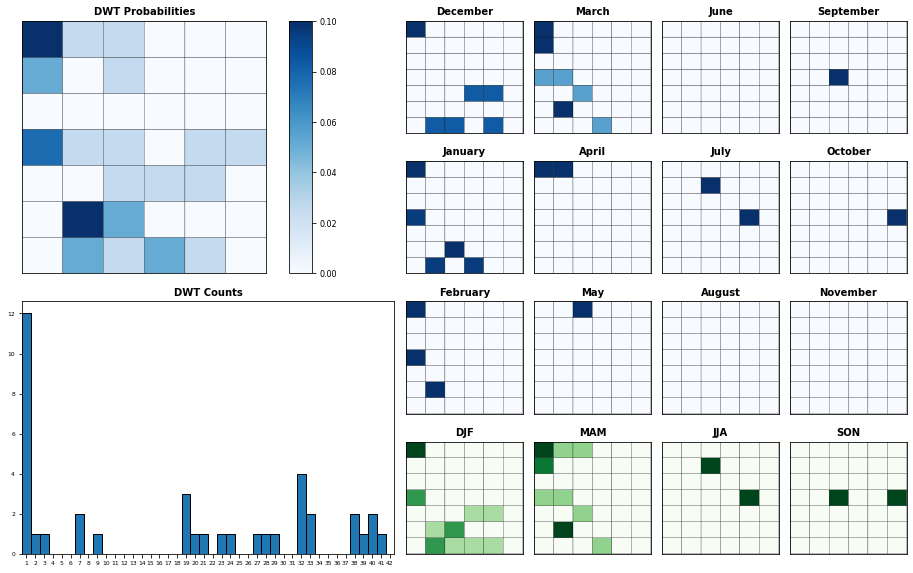

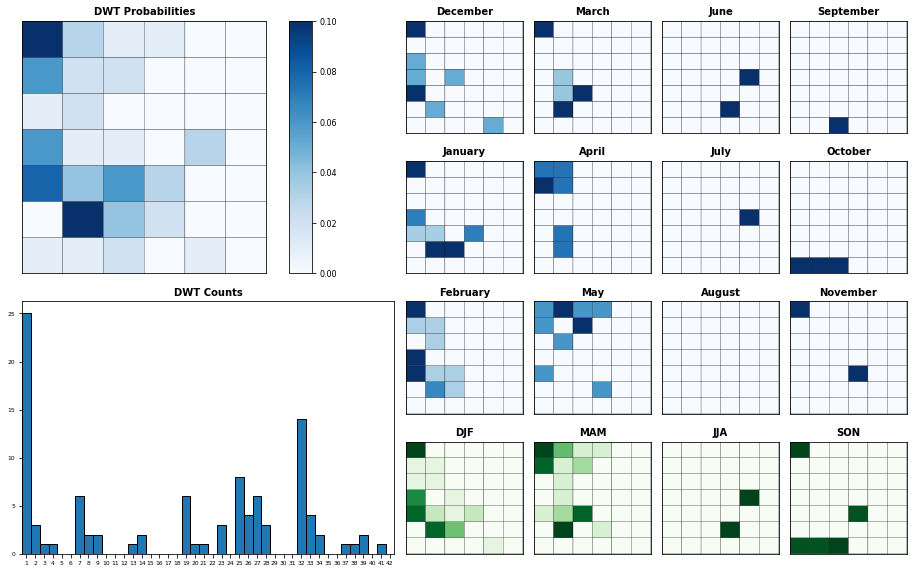

In [33]:
# Plot Annual Maxima DWT probabilities by month
n_clusters_DWT = 42   # number of DWT clusters

# Historical
Plot_DWTs_Probs(HIST_C_h_Amax['DWT'].values, HIST_C_h_Amax.time.values, n_clusters_DWT);

# Simulation
Plot_DWTs_Probs(offshore_vars_AMax['DWT'].values, offshore_vars_AMax.time.values, n_clusters_DWT);

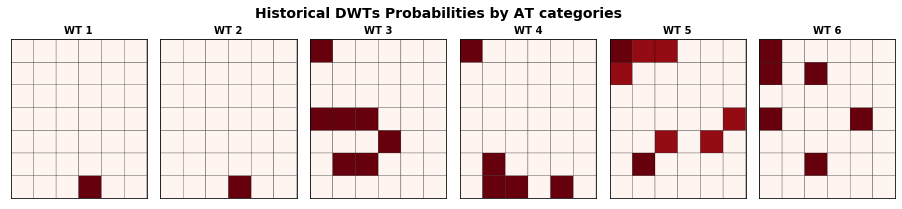

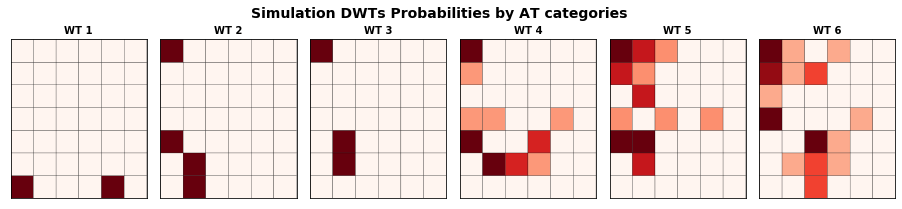

In [34]:
# Plot Annual Maxima DWT probabilities by AT category (1-6)
#AT cat 1: <0
#AT cat 2: 0 - 0.3039 [perc 50%]
#AT cat 3: 0.3039 - 0.4972 [perc 75%]
#AT cat 4: 0.4972 - 0.77 [perc 95%]
#AT cat 5: 0.77 - 0.9031 [perc 99%]
#AT cat 6: 0.9031 - 1.068 [perc 100%]

n_clusters_AT = 6
AT_amp = 42

# Historical
AT_amp = HIST_C_h_Amax['AT_category'].values-1
DWT_bmus = HIST_C_h_Amax['DWT'].values-1

Plot_Probs_WT_WT(
    AT_amp, DWT_bmus, n_clusters_AT, n_clusters_DWT,
    wt_colors=False, ttl='Historical DWTs Probabilities by AT categories');


# Simulation
AT_amp = offshore_vars_AMax['AT_category'].values-1
DWT_bmus = offshore_vars_AMax['DWT'].values-1

Plot_Probs_WT_WT(
    AT_amp, DWT_bmus, n_clusters_AT, n_clusters_DWT,
    wt_colors=False, ttl='Simulation DWTs Probabilities by AT categories');
